Primero importamos las librerias nescesarias como torch para poder usar las funciones del frame pytorch 


In [139]:
#Importar librerias necesarias
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

#Verificar si hay gpu disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


Ahora solo vamos a asignar un indice, cdigo y asociarlos a los nombres de las clases
Es recomendable trabajar con indices y codigos para las clases ya que son unicos y los nombres se podrian 
repetir en datasets grandes, por esta razon es recomendable trabajar de esta manera

In [141]:
import os

# Ruta del dataset
dataset_path = r"../Datasets/train"  # Accedemos a la carpeta train del dataset

# Obtener nombres de clases desde las carpetas
clases = sorted(os.listdir(dataset_path))

# Generar códigos únicos tipo 'nXXXXX' para cada clase (es recomendable usar un prefijo único especialmente en datasets con muchas clases)
code_prefix = "n"
class_codes = {clase: f"{code_prefix}{str(i).zfill(5)}" for i, clase in enumerate(clases)}


# Crear mapeos
index_to_code = {i: class_codes[clase] for i, clase in enumerate(clases)}  # Mapeo de clase a código, asignando un índice a cada clase
code_to_class = {class_codes[clase]: clase for clase in clases}   # Mapeo de código a clase
index_to_class = {i: clase for i, clase in enumerate(clases)}    # Mapeo de índice a clase
# Guardar en un archivo TXT con formato código <tab> descripción
words_path = "clases_descripcion.txt"

with open(words_path, "w") as f:
    for code, clase in code_to_class.items():
        f.write(f"{code}\t{clase}\n")

print(f"Archivo guardado en: {words_path}")

# Cargar el archivo de texto y crear un diccionario de descripciones
class_descriptions = {}

with open("clases_descripcion.txt", "r") as f:
    for line in f:
        code, description = line.strip().split("\t")  # Separa por tabulación
        class_descriptions[code] = description  # Guarda en el diccionario

# Mostrar resultado
print(class_descriptions)


# Crear un DataFrame para visualizar
import pandas as pd
data = [{"Índice": i, "Código": index_to_code[i], "Nombre": index_to_class[i]} for i in range(len(clases))]   #solo mapea el índice a la clase y al código
df = pd.DataFrame(data)

# Mostrar resultado
print(df)


Archivo guardado en: clases_descripcion.txt
{'n00000': 'bird', 'n00001': 'cat', 'n00002': 'deer', 'n00003': 'dog', 'n00004': 'frog', 'n00005': 'horse', 'n00006': 'ship', 'n00007': 'truck'}
   Índice  Código Nombre
0       0  n00000   bird
1       1  n00001    cat
2       2  n00002   deer
3       3  n00003    dog
4       4  n00004   frog
5       5  n00005  horse
6       6  n00006   ship
7       7  n00007  truck


Ahora cargamos tanto las imagenes de entrenamiento como las de prueba:
-Primero redimensionamos, transformamos a tensor y normalizamos el tamaño de las imagenes
-Luego cargamos datos de entrenamiento en train
-Cargamos imagenes en batches de 4 para que el modelo reciba 4 imagenes a la vez en lugar de una sola y las cargamos aleatoriamente para que cada
  vez que cargue salgan de diferente forma y no sea siempre el msimo orden ya que podria memorizar en lugar de aprender

In [143]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
# Transformaciones: redimensionar y convertir en tensor
transform_train = transforms.Compose([
    transforms.Resize((32, 32)),  # Redimensionar imágenes (por precaucion, si hay imagenes de diferente tamaño las vuelve 32x32)
    transforms.RandomHorizontalFlip(),  # Voltea imágenes aleatoriamente
    transforms.RandomRotation(20),      # Rotación aleatoria
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Variación de color
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Pequeños desplazamientos
    
    transforms.ToTensor(),  # Convertir a tensor
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar (usa la media y desviacion estandar, como son imagenes a color RGB son 3 colores)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Cargar el conjunto de datos para entrenamiento
traindata = torchvision.datasets.ImageFolder(              #cargamos las imagenes de la carpeta train, cada carpeta dentro de train es una clase 
    root=r"../Datasets/train/",
    transform=transform_train             #Aplicamos las transformaciones anteriores
)

train_loader = DataLoader(traindata, batch_size=64, shuffle=True)      #cargamos imagenes en batches de 4 imagenes para optimizar y las organizamos aleatoriamente


# Cargar el conjunto de datos para prueba
testdata = torchvision.datasets.ImageFolder(
    root=r"../Datasets/test/",
    transform=transform_test
)
test_loader = DataLoader(testdata, batch_size=64, shuffle=True)  # Batch size de 5 para visualizar
# Verificar los tamaños de los datasets
print(f"Tamaño del conjunto de entrenamiento: {len(traindata)} imágenes")
print(f"Tamaño del conjunto de prueba: {len(testdata)} imágenes")

Tamaño del conjunto de entrenamiento: 48158 imágenes
Tamaño del conjunto de prueba: 4692 imágenes


Ahora es momento de aplicar las capas ocultas, en este caso usaremos 4
Luego usamos la funcion de activacion ReLU exceptuando la ultima capa que no se activara ya que usaremos en la fase de entrenamiento 

In [144]:
# Definir la red neuronal (MLP)
class Net(nn.Module):     #la clase es herencia de la clase nn.Module de Pytorch para poder aprovechar sus funcionalidades
    def __init__(self):    #Definimos las capas de la red neuronal
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)  # Primera capa: 3072 entradas (3 canales * 32x32 píxeles)
        self.fc2 = nn.Linear(512, 256)         # Segunda capa: 1024 entradas -> 512 salidas
        self.fc3 = nn.Linear(256, 128)         # Tercera capa: 512 entradas -> 256 salidas
        self.fc4 = nn.Linear(128, 64)         # Cuarta capa: 256 entradas -> 128 salidas (clases)
        self.fc5 = nn.Linear(64, 8)            #Quinta capa: 128 entradas -> 64 salidas
      #  self.fc6 = nn.Linear(32, 8)          # Capa de salida: 64 entradas -> 8 clases (salidas)

    def forward(self, x):     #Definir el paso hacia adelante
        # Aplanar las imágenes y ajustar para procesar linealmente 
        x = x.view(-1, 3 * 32 * 32)  # -1 ajusta automáticamente el tamaño del lote por bath/tensor
        # Pasar a través de las capas con activación ReLU, funcion de activacion
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
       # x = torch.relu(self.fc5(x))
        x = self.fc5(x)  # La última capa no tiene activación, capa de salida. Pasara luego por una funcion de activacion
        return x

# Instanciar el modelo y moverlo al dispositivo adecuado (CPU o GPU)
model = Net().to(device)

# Mostrar detalles del modelo
print(model)

Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=8, bias=True)
)


Definimos la funcion de perdida usando Softmax + Negative Log Likelihood Loss (NLLLoss) usando probabilidades y perdidas
Realizamos una optimizacion usando Descenso de Gradiente Estocástico (SGD)
Usamos SGD en lugar del descenso comun ya que utiliza un ejemplo por iteracion a comparacion del normal que usa todo el dataset
Obtenemos pesos y sesgos del modelo
Mientras la taza de prendizaje sea mas baja sera un aprendizaje mas estabe pero lento, mientras que mas alta mas rapido pero con oscilaciones   
Usamos el momentum para ir actualizando el gradiente conforme a los pesos anteriores     


In [145]:
# Definir el criterio de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()  # Función de pérdida para problemas de clasificación,Combina Softmax + Negative Log Likelihood Loss (NLLLoss) internamente.
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Optimización con SGD, obteniendo los pesos y sesgos del modelo con taza de aprndizaje 0.001 y momentum 0.9
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, weight_decay=1e-4)

#estaba 11 con 0.005 y 0.9 
#9 con 0.0001 y 0.5
#optimizer = torch.optim.Adam(model.parameters(), lr=0.005)  # Optimizador Adam, más eficiente que SGD en muchos casos
#optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-8)
#optimizer = optim.Adam(model.parameters(), lr=0.0005    , weight_decay=1e-4)  # Optimizador Adam con decaimiento de peso, agustar gradiente

# Configurar cuDNN para mejorar el rendimiento en GPUs
torch.backends.cudnn.benchmark = True

# Mostrar configuración
print("Criterio de pérdida: CrossEntropyLoss")
#print("Optimizador: SGD con tasa de aprendizaje 0.001 y momentum 0.9")

Criterio de pérdida: CrossEntropyLoss


Aqui solo mapeamos los indices, codigos y nombres de cada clase para ver que clase corresponde a que numero de codigo e indice

In [146]:
# Obtener nombres de las clases desde el dataset
class_names = traindata.classes
print(f"Clases definidas en el conjunto de entrenamiento: {class_names}")

# Mostrar el mapeo entre índices, códigos y descripciones
print("\nMapeo de índices, códigos y descripciones:")
print(f"{'Índice':<10}{'Código':<15}{'Descripción'}")
print("-" * 45)
for i in range(8):
    code = index_to_code[i]
    desc = class_descriptions[code].split(',')[0]  # Usar solo la primera parte de la descripción para simplificar
    print(f"{i:<10}{code:<15}{desc}")

Clases definidas en el conjunto de entrenamiento: ['bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Mapeo de índices, códigos y descripciones:
Índice    Código         Descripción
---------------------------------------------
0         n00000         bird
1         n00001         cat
2         n00002         deer
3         n00003         dog
4         n00004         frog
5         n00005         horse
6         n00006         ship
7         n00007         truck


Aqui solo mostramos imagenes de nuestros datasets, el de prueba y de entrenamiento

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


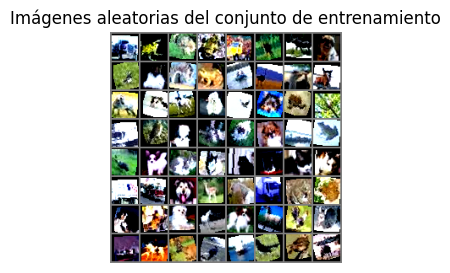

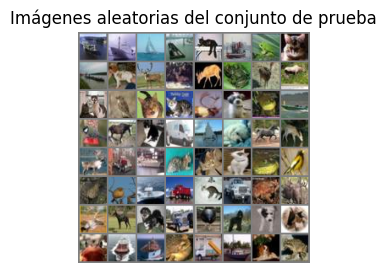

In [147]:
# Función para mostrar imágenes sin clasificación
def show_random_images(loader, num_images=4, title="Imágenes aleatorias del dataset"):
    dataiter = iter(loader)
    images, _ = next(dataiter)
    img = torchvision.utils.make_grid(images)
    img = img / 2 + 0.5
    npimg = img.numpy()

    plt.figure(figsize=(6, 3))
    plt.title(title)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Probar la función con conjuntos de datos
show_random_images(train_loader, title="Imágenes aleatorias del conjunto de entrenamiento")
show_random_images(test_loader, title="Imágenes aleatorias del conjunto de prueba")

Aqui empezamos a entrenar al modelo
Cada epoca sera una iteracion del entrenamiento pero las imagenes estaran en diferente orden
Calculamos las metricas (Perdida y presicion)
Calculamos las probabilidades y contamos los aciertos
Actualizamos resultados y mostramos en tabla

In [148]:
from IPython.display import display, clear_output
import pandas as pd

# Función de entrenamiento con impresión en columnas
def train(epochs):
    model.train()  # Establecer el modelo en modo de entrenamiento
    
    # Listas para almacenar métricas
    epoch_list = []      #Numero de epocas
    train_loss_list = []      #Pérdida de entrenamiento
    train_acc_list = []      #Precisión de entrenamiento

    # Cada iteracion es una epoca
    for epoch in range(epochs):     #inicializar metricas
        running_loss = 0.0     # Pérdida acumulada
        correct = 0     # Correctos acumulados
        total = 0     # Total de imágenes procesadas
        
        # Entrenar por lotes
        for i, (inputs, labels) in enumerate(train_loader):  #inputs son las imagenes(batchs) y labels son las etiquetas
            inputs, labels = inputs.to(device), labels.to(device)

            # Reiniciar gradientes
            optimizer.zero_grad()

            # Forward, backward y optimización
            outputs = model(inputs)    # Pasar las imagenes por la red neuronal, predicciones para el batch actual
            loss = criterion(outputs, labels)
            loss.backward()   # Calcular gradientes para cada peso y sesgo de la red neuronal
            optimizer.step()    # Actualizar pesos y sesgos de la red neuronal

            # Calcular métricas
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)   # Obtener la clase predicha (la de mayor probabilidad)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()   # Contar aciertos
        
        # Calcular métricas por época
        epoch_loss = running_loss / len(train_loader)     # Pérdida promedio por época
        epoch_acc = 100 * correct / total     # Precisión promedio por época
        
        # Almacenar métricas
        epoch_list.append(epoch + 1)
        train_loss_list.append(epoch_loss)
        train_acc_list.append(epoch_acc)
        
        # Mostrar resultados actualizados en columnas
        metrics_table = pd.DataFrame({
            "Época": epoch_list,
            "Pérdida": train_loss_list,
            "Precisión (%)": train_acc_list
        })
        
        clear_output(wait=True)  # Limpiar salida previa
        display(metrics_table)  # Mostrar tabla con resultados

    print("Entrenamiento completado")
    return epoch_list, train_loss_list, train_acc_list

Entrenar modelo/mandar epocas

In [149]:
# Entrenar el modelo y mostrar los resultados en columnas
epochs, loss_history, acc_history = train(epochs=50)

,Época,Pérdida,Precisión (%)
0,1,2.066625,17.594169
1,2,1.933857,24.861913
2,3,1.802092,29.741684
3,4,1.745276,33.118070
4,5,1.687955,35.865277
5,6,1.634487,38.093359
6,7,1.587958,39.978820
7,8,1.549812,41.700237
8,9,1.517268,43.270069
9,10,1.489796,44.407990


Entrenamiento completado


Evaluamos el aprendizaje cambiando el modelo al modo de evaluacion y comparando con el dataset de prueba
Calculamos la precision del conjunto

In [150]:
from tqdm import tqdm

def evaluate():
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluando"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Precisión en el conjunto de prueba: {accuracy:.2f}%")
    return accuracy

# Llamar a la función de evaluación
print("\n--- EVALUANDO MODELO EN CONJUNTO DE PRUEBA ---")
test_accuracy = evaluate()


--- EVALUANDO MODELO EN CONJUNTO DE PRUEBA ---


Evaluando: 100%|██████████| 74/74 [00:02<00:00, 32.53it/s]

Precisión en el conjunto de prueba: 46.72%


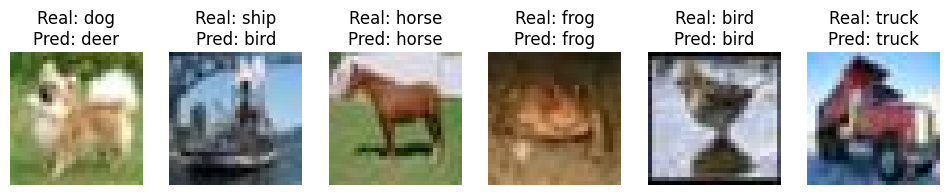

In [157]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Función para obtener el nombre de la clase predicha
def get_class_name(index):
    return testdata.classes[index]

# Buscar imágenes de distintas clases
def get_images_from_different_classes(data_loader, num_classes=5):
    class_samples = {}
    for images, labels in data_loader:
        for img, label in zip(images, labels):
            label = label.item()
            if label not in class_samples:
                class_samples[label] = (img, label)
            if len(class_samples) == num_classes:
                break
        if len(class_samples) == num_classes:
            break
    return list(class_samples.values())

# Obtener imágenes de diferentes clases
samples = get_images_from_different_classes(test_loader, num_classes=6)

# Convertir imágenes a batch y enviar a dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images, labels = zip(*samples)
images = torch.stack(images).to(device)
labels = torch.tensor(labels).to(device)

# Obtener predicciones del modelo
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Mostrar imágenes con predicciones
fig, axes = plt.subplots(1, len(samples), figsize=(12, 4))
for i, (img, label, pred) in enumerate(zip(images, labels, predicted)):
    img = img.cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5  # Desnormalizar
    axes[i].imshow(img)
    axes[i].set_title(f"Real: {get_class_name(label.item())}\nPred: {get_class_name(pred.item())}")
    axes[i].axis("off")
plt.show()
